In [17]:
%load_ext autoreload
%autoreload 2
import xgboost as xgb
import pandas as pd
import numpy as np
from utils import k_fold_cross_validation_regression, mse_mae_mape


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
df_train = pd.read_csv('data/data_processed_train_merged.csv')
df_test = pd.read_csv('data/data_processed_test_merged.csv')
df = pd.concat((df_train, df_test), ignore_index=True)

string_cols = ['survey_language', 'disability']
df[string_cols] = df[string_cols].astype('category')
df[string_cols] = df[string_cols].apply(lambda x: x.cat.codes)

## Transform distance into log scale
$new\_dist = log_2dist$

In [8]:
df['trip_distance'] = np.log2(df['trip_distance'])
df

,id,person_id,trip_n,travel_date,travel_date_dow,o_purpose_category,d_purpose_category,num_non_hh_travelers,num_hh_travelers,num_travelers,...,num_students,disability,trip_distance,mode,trip_distance_category,age_merged,income_aggregate_merged,res_type_merged,education_merged,travel_date_dow_merged
0,0,0,0,30/05/2019,4,7,2,0,1,1,...,2,3,3.744161,subway,long,1,1,0,1,0
1,1,0,1,01/06/2019,6,6,1,0,1,1,...,2,3,1.887525,drive,long,1,1,0,1,1
2,2,0,2,02/06/2019,7,7,7,1,2,3,...,2,3,3.292782,drive,long,1,1,0,1,1
3,3,0,3,02/06/2019,7,7,7,1,2,3,...,2,3,3.472488,drive,long,1,1,0,1,1
4,4,0,4,03/06/2019,1,7,7,0,1,1,...,2,3,1.321928,drive,medium,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65733,65787,2991,48,27/06/2019,4,8,8,2,2,4,...,0,4,NaN,NaN,NaN,1,0,2,0,0
65734,65788,2991,49,27/06/2019,4,8,8,2,2,4,...,0,4,NaN,NaN,NaN,1,0,2,0,0
65735,65789,2991,50,27/06/2019,4,8,8,2,2,4,...,0,4,NaN,NaN,NaN,1,0,2,0,0
65736,65790,2991,51,27/06/2019,4,8,8,2,2,4,...,0,4,NaN,NaN,NaN,1,0,2,0,0


In [9]:
candidate_cols = [
#      'travel_date_dow',
     'o_purpose_category',
     'd_purpose_category',
#      'num_non_hh_travelers',
#      'num_hh_travelers',
     'num_travelers',
#      'o_location_type',
#      'd_location_type',
#      'o_congestion',
     'd_congestion',
#      'age',
#      'employment',
#      'student',
     'license',
#      'planning_apps',
#      'industry',
#      'gender',
#      'education',
#      'survey_language',
#      'num_bicycles',
     'num_vehicles',
#      'res_type',
     'rent_own',
#      'income_aggregate',
#      'num_people',
#      'num_adults',
#      'num_kids',
#      'num_workers',
#      'num_students',
#      'disability'
#     'trip_distance'
    'res_type_merged',
    'income_aggregate_merged',
    'age_merged',
    'travel_date_dow_merged',
    'education_merged'
]


categorial_columns = ['travel_date_dow', 'o_purpose_category', 'd_purpose_category', 'o_location_type',
                      'd_location_type', 'age', 'employment', 'license', 'planning_apps', 'industry',
                      'gender', 'survey_language', 'res_type', 'rent_own',  'disability']

onehot = pd.get_dummies(df[candidate_cols], columns=[x for x in categorial_columns if x in candidate_cols])

X_train_val = onehot.to_numpy()[:len(df_train)]
group_train_val = df['person_id'].to_numpy()[:len(df_train)]
y_train_val = df['trip_distance'][:len(df_train)]

X_test = onehot.to_numpy()[len(df_train):]


In [10]:
model = xgb.XGBRegressor(objective='reg:squarederror', # objective_mape or 'reg:squarederror'
                          n_estimators = 100,
                          n_jobs=-1,
                          random_state=42,
                          use_label_encoder =False)

train_metrics, val_metrics = k_fold_cross_validation_regression(X_train_val, y_train_val, group_train_val, model)


In [11]:
metrics = np.concatenate((train_metrics, val_metrics), axis=1)
metrics = metrics[:,[0, 3, 1, 4, 2, 5]]
train_metrics_df = pd.DataFrame(metrics, columns=['mse-train', 'mse-val', 'mae-train', 'mae-val', 'mape-train', 'mape-val'])
train_metrics_df

,mse-train,mse-val,mae-train,mae-val,mape-train,mape-val
0,2.832343,3.839794,1.377225,1.618376,5.402182e+13,6.355244e+13
1,2.847411,3.876990,1.377881,1.635056,5.755222e+13,5.913554e+13
2,2.841127,3.879808,1.377571,1.631376,5.741540e+13,6.248918e+13
3,2.866688,3.777479,1.387314,1.602532,5.679019e+13,5.800605e+13
4,2.889038,3.692464,1.392188,1.583338,5.323201e+13,7.853155e+13


## Hyperparameter search

In [15]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV, GroupKFold

distributions = {
    'learning_rate': loguniform(10**-5, 1),
#     'max_depth': [2, 4, 6, 8]
}

k_fold = GroupKFold(n_splits=5)
search = RandomizedSearchCV(model,
                            distributions,
                            random_state=1,
                            n_jobs=4,
                            scoring='neg_mean_squared_error', # 'neg_mean_squared_error' or 'neg_mean_absolute_percentage_error'
                            n_iter=10,
                            cv=k_fold
                           ).fit(X_train_val, y_train_val, groups=group_train_val)
print('best parameter', search.best_params_)
print('best score', search.best_score_)


/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated an

best parameter {'learning_rate': 0.03995972283135063}
best score -3.6225588105151387


In [26]:
search.cv_results_

{'mean_fit_time': array([8.27785816, 8.23126364, 8.37262926, 8.51516647, 8.5367651 ,
        8.45705004, 8.48336239, 8.44908638, 8.72131   , 6.90284576]),
 'std_fit_time': array([0.11416734, 0.06374142, 0.08875688, 0.08827849, 0.12907577,
        0.03112605, 0.08870074, 0.0900788 , 0.22575376, 1.91892205]),
 'mean_score_time': array([0.00979939, 0.01095715, 0.01103878, 0.00961866, 0.01123719,
        0.01163635, 0.01050868, 0.01041384, 0.01392894, 0.01602602]),
 'std_score_time': array([0.00106593, 0.00186699, 0.00105579, 0.00128033, 0.00209003,
        0.00120802, 0.0027242 , 0.00111447, 0.00219296, 0.00908326]),
 'param_learning_rate': masked_array(data=[0.001216494146415184, 0.03995972283135063,
                    1.0013176560941263e-05, 0.00032483503450866794,
                    5.4172571827679706e-05, 2.8952960233492824e-05,
                    8.536916958038756e-05, 0.000534322712559412,
                    0.0009634681692624377, 0.004944059287398676],
              mask=[False

## train model on whole dataset

In [18]:
## model parameter from search results
model = xgb.XGBRegressor(objective='reg:squarederror', # reg:squarederror
                         n_estimators = 100,
                         learning_rate=0.0399, 
                         n_jobs=-1,
                         random_state=42,
                         use_label_encoder =False)

model.fit(X_train_val, y_train_val)

# calculate training metrics
y_train_val_pred = model.predict(X_train_val)
print(mse_mae_mape(y_train_val, y_train_val_pred))

(3.422992506290909, 1.5479004414964324, 48215055510539.945)


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

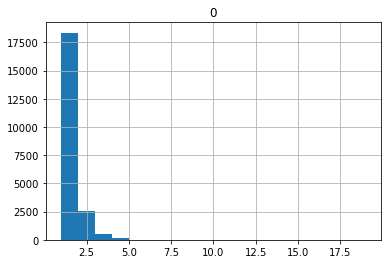

In [24]:
pd.DataFrame(2**y_train_val_pred).hist(bins=range(1,20))

array([[<AxesSubplot:title={'center':'trip_distance'}>]], dtype=object)

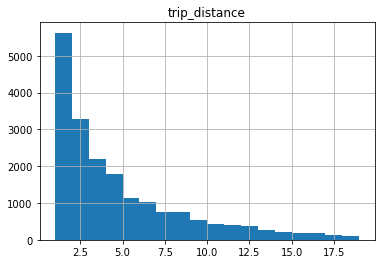

In [26]:
pd.DataFrame(2**y_train_val).hist(bins=range(1,20))

## Read test data


In [27]:
y_train_val_pred = model.predict(X_train_val)
y_test_pred = model.predict(X_test)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

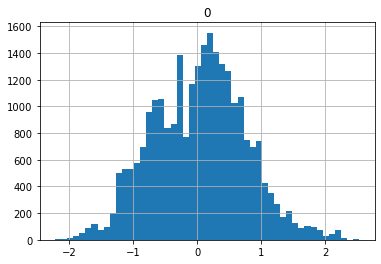

In [28]:
pd.DataFrame(y_test_pred).hist(bins=50)

In [29]:
# Append prediction to dataset
df_train['trip_distance'] = y_train_val_pred
df_test['trip_distance'] = y_test_pred

,Unnamed: 0,id,person_id,trip_n,travel_date,travel_date_dow,o_purpose_category,d_purpose_category,num_non_hh_travelers,num_hh_travelers,...,res_type,rent_own,income_aggregate,num_people,num_adults,num_kids,num_workers,num_students,disability,trip_distance
0,0,39498,1795,0,07/06/2019,5,1,6,0,1,...,6,2,1,2,2,0,1,1,none,1.060259
1,1,39499,1795,1,07/06/2019,5,6,6,0,1,...,6,2,1,2,2,0,1,1,none,1.060259
2,2,39500,1795,2,07/06/2019,5,6,1,0,1,...,6,2,1,2,2,0,1,1,none,1.635832
3,3,39501,1796,0,05/06/2019,3,1,6,0,1,...,5,2,1,2,1,1,0,2,none,1.205747
4,4,39502,1796,1,05/06/2019,3,6,7,0,1,...,5,2,1,2,1,1,0,2,none,1.039199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26289,26289,65787,2991,48,27/06/2019,4,8,8,2,2,...,5,2,2,2,2,0,2,0,none,0.345874
26290,26290,65788,2991,49,27/06/2019,4,8,8,2,2,...,5,2,2,2,2,0,2,0,none,0.345874
26291,26291,65789,2991,50,27/06/2019,4,8,8,2,2,...,5,2,2,2,2,0,2,0,none,0.345874
26292,26292,65790,2991,51,27/06/2019,4,8,8,2,2,...,5,2,2,2,2,0,2,0,none,0.345874


In [30]:
# save test data with trip_distance predictions to file
df_train.to_csv('data/xgboost_distance_regression_merged_log_train', index=False)
df_test.to_csv('data/xgboost_distance_regression_merged_log_test', index=False)